In [1]:
%matplotlib inline

In [84]:
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skimage.io as io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from nilearn.input_data import NiftiMasker
import seaborn as sns
from scipy import stats
from brainsmash.mapgen.sampled import Sampled
from brainsmash.mapgen.eval import sampled_fit

In [85]:
data_dir = '/home/julia/data/gradients/'

In [4]:
mask_img = nb.load(data_dir + 'allen_atlas/cortex_mask_tight_200um.nii.gz')
mask = np.array(mask_img.dataobj)
aff = mask_img.affine
hdr = mask_img.header

In [20]:
df = pd.read_csv(data_dir + "allen_atlas/gene_expression/gene_list_full_fixed.csv")
df = df[np.isnan(df['entrez'])==False]
df = df.reset_index(drop=True)

In [40]:
len(df)

4375

### Make a mask that has data in >50% of gene maps

In [22]:
ids = list(df['id'])
gene_mask = np.zeros(mask.shape)
n_maps = 0
miss = []
for n in range(len(ids)):
    try:
        # load and save as nifti
        gene = np.swapaxes(io.imread(data_dir + 'allen_atlas/gene_expression/energy/%s/energy.mhd'% ids[n],
                                      plugin='simpleitk'), 
                            0,2)[:-1,:-1,:-1]
        nb.save(nb.Nifti1Image(gene, aff, hdr), data_dir + 
                                                'allen_atlas/gene_expression/energy/%s/energy.nii.gz'% ids[n])
        
        # count how many maps have data in a given voxel
        gene_mask[np.where(gene >= 0)] += 1
        n_maps += 1

    except RuntimeError:
        miss.append(ids[n])
        pass

gene_mask[mask==0] = 0

In [41]:
# Drop entries that don't have a map from dataframe
for m in miss:
    df = df.drop(df[df['id']==m].index.values[0])
df = df.reset_index(drop=True)

In [42]:
len(df)

4128

In [43]:
# Create a mask that is covered at least by half of the expression data
gene_mask_thr = np.zeros(mask.shape)
gene_mask_thr[gene_mask >= (n_maps/2)] = 1
nb.save(nb.Nifti1Image(gene_mask_thr, aff, hdr), data_dir+'allen_atlas/gene_expression/gene_mask.nii.gz')

### Combine energy for experiments probing the same gene (entrez)

In [44]:
# Smooth while loading and compressing
masker = NiftiMasker(mask_img=nb.Nifti1Image(gene_mask_thr, aff, hdr), 
                     standardize=False, smoothing_fwhm=0.45)

In [46]:
entrez = np.unique(df['entrez'])
energy = np.zeros((np.where(gene_mask_thr==1)[0].shape[0], entrez.shape[0]))

for e in range(entrez.shape[0]):
    # find all probes for that gene
    probes = list(df[df['entrez']==entrez[e]]['id'])
    
    gene = np.zeros(mask.shape)
    for p in probes:
        # load nifti
        gene += np.array(nb.load(data_dir+'allen_atlas/gene_expression/energy/%s/energy.nii.gz'% p).dataobj)
    gene = gene / len(probes)
    
    # smooth and add to gene matrix            
    energy[:,e] = masker.fit_transform(nb.Nifti1Image(gene, aff, hdr))

In [47]:
len(entrez)

3956

In [48]:
np.save(data_dir+'allen_atlas/gene_expression/energy.npy', energy)

In [49]:
df_energy = pd.DataFrame(index=entrez, data=energy.T)
df_energy.to_csv(data_dir + 'allen_atlas/gene_expression/energy.csv')

### Normalize gene expression data using sigmoid function and standard rescaling

In [50]:
energy = np.load(data_dir + 'allen_atlas/gene_expression/energy.npy')

In [51]:
def sigmoid(energy):
    X = (energy - np.mean(energy)) / np.std(energy)
    sig = 1 / (1 + np.exp(-X))
    return sig

In [52]:
sigmoid_energy = np.zeros_like(energy)
for e in range(energy.shape[1]):
    sigmoid_energy[:,e] = sigmoid(energy[:,e])

In [53]:
# Standardizing the features
standard_energy = StandardScaler().fit_transform(sigmoid_energy)

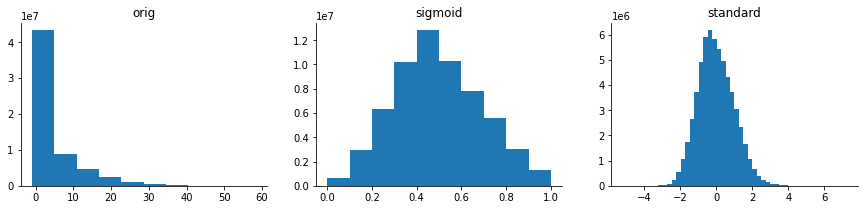

In [54]:
fig = plt.figure(figsize=(15,3))
fig.add_subplot(1,3,1)
plt.hist(energy.flatten());
plt.title('orig')
fig.add_subplot(1,3,2)
plt.hist(sigmoid_energy.flatten());
plt.title('sigmoid')
fig.add_subplot(1,3,3)
plt.hist(standard_energy.flatten(), bins=50);
plt.title('standard')
sns.despine()

### Run PCA

In [64]:
pca = PCA(n_components=500)
pcs = pca.fit_transform(standard_energy)

In [65]:
comp05 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.5)[0][0]
comp09 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9)[0][0]

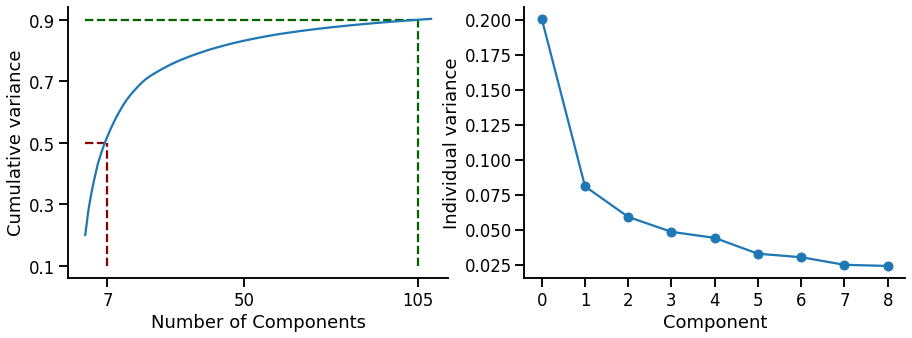

In [66]:
#Plotting the Cumulative Summation of the Explained Variance
sns.set_context("talk")
fig = plt.figure(figsize=(15,5))

fig.add_subplot(121)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:110])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance') 
plt.xticks([comp05, 50, comp09])
plt.yticks([0.1, 0.3, 0.5, 0.7, 0.9])
plt.hlines(0.9, 0, comp09, color='darkgreen', linestyle="--")
plt.vlines(comp09, 0.1, 0.9, color='darkgreen', linestyle="--")
plt.hlines(0.5, 0, comp05, color='darkred', linestyle="--")
plt.vlines(comp05, 0.1, 0.5, color='darkred', linestyle="--")
sns.despine()

fig.add_subplot(122)
plt.plot(pca.explained_variance_ratio_[:9], 'o', linestyle="-")
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.xlabel('Component')
plt.ylabel('Individual variance') 
sns.despine()

In [67]:
np.save(data_dir + 'results/gene_expression/pca_components.npy', pcs)

### Save first six PCAs as images

In [68]:
pca_img = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2], 6))
for p in range(6):
    pca_img[:,:,:,p] = masker.inverse_transform(pcs[:,p]).get_data()
nb.save(nb.Nifti1Image(pca_img, aff, hdr), data_dir + 'results/gene_expression/pca_img.nii.gz')

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


### Plot

In [69]:
x=30
y=12
z=20

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.
/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


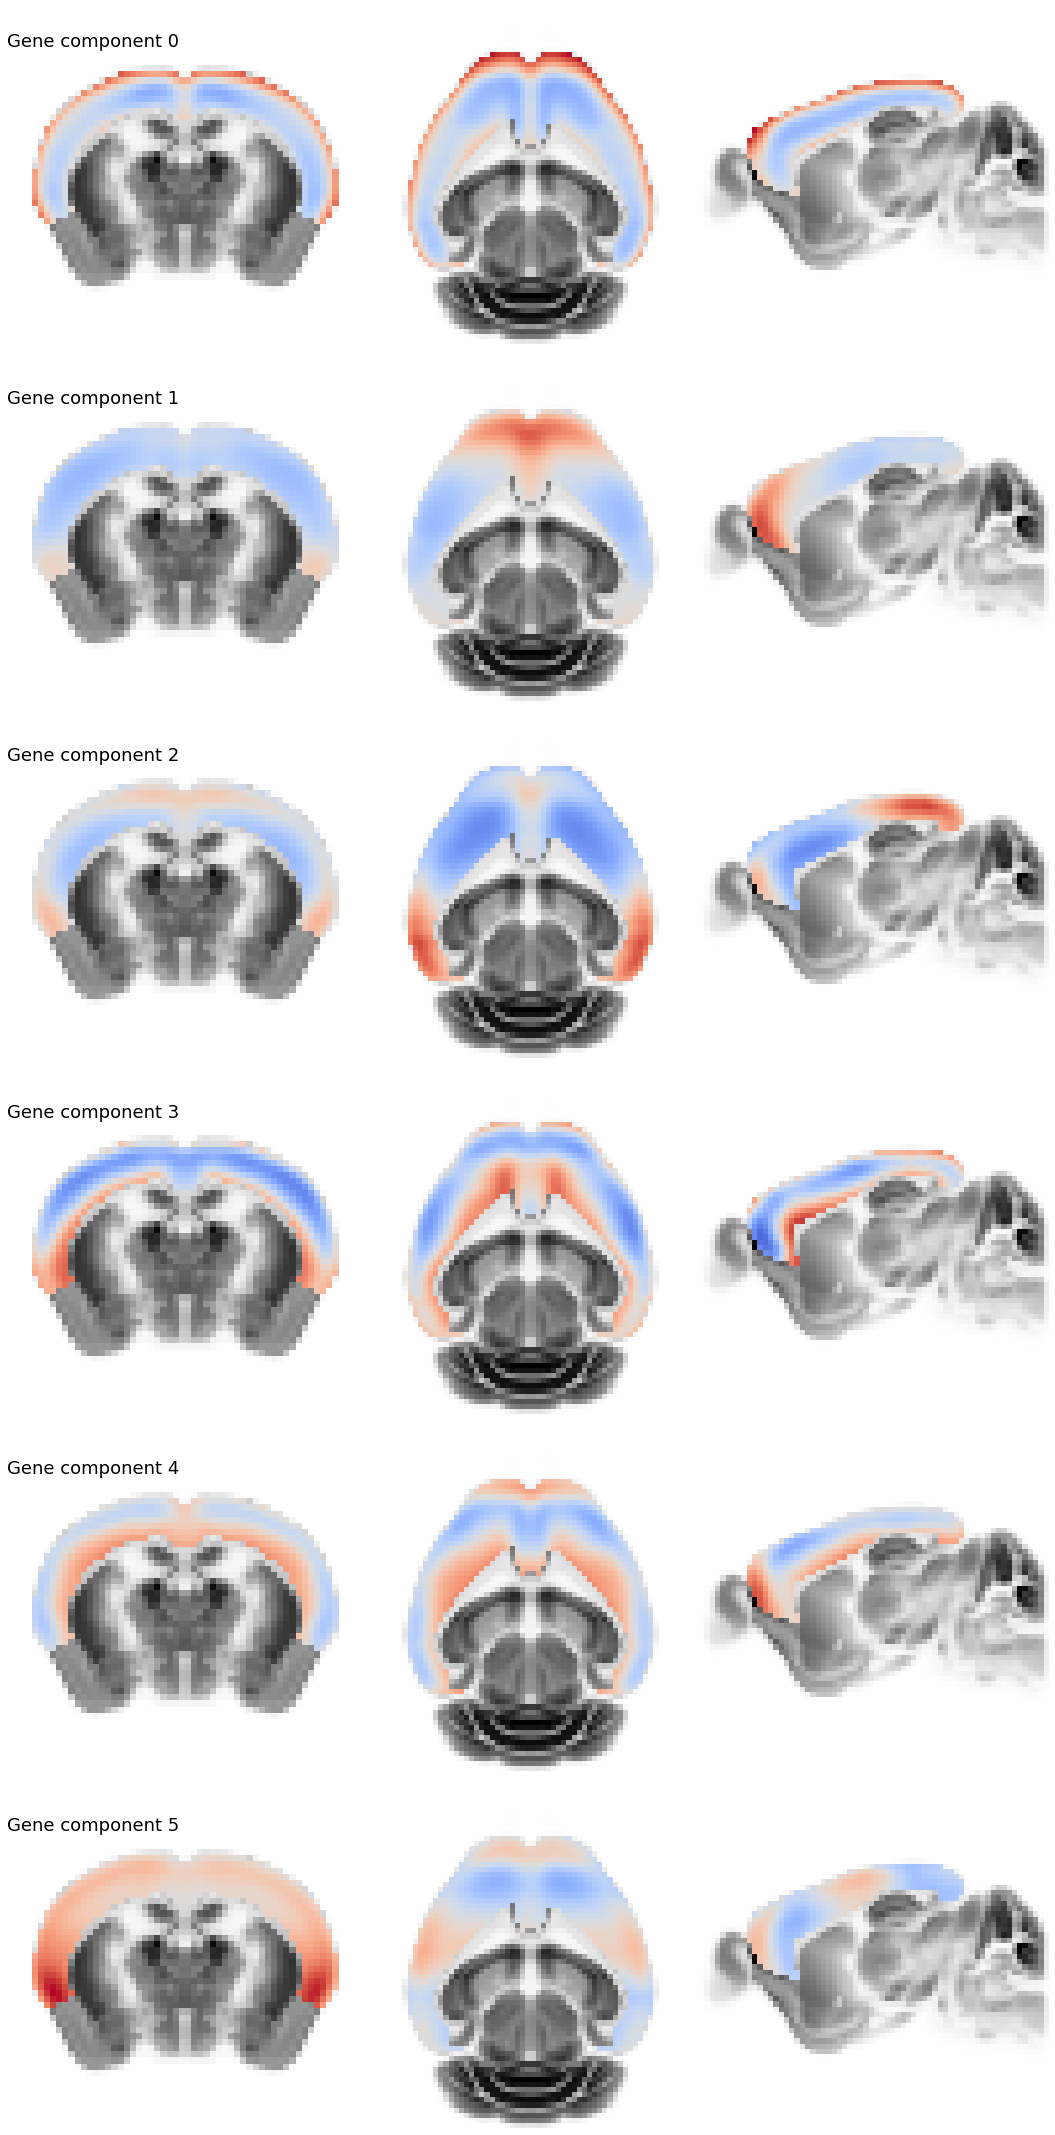

In [70]:
template = nb.load(data_dir+'allen_atlas/template_200um.nii.gz').get_data()
gradients = nb.load(data_dir + 'results/gene_expression/pca_img.nii.gz').get_data()
fig = plt.figure(figsize=(15,30))
for g in range(6):
    
    gradient = gradients[:,:,:,g]
    gradient[gene_mask_thr==0] = np.nan
    vmax = np.max([np.abs(np.nanmin(gradient)), np.abs(np.nanmax(gradient))])
    vmin = -vmax
    
    template_img = [template[x,:,:], template[:,y,:], template[:,:,z].T]
    gradient_img = [gradient[x,:,:], gradient[:,y,:], gradient[:,:,z].T]
    
    for i in range(3):
        
        fig.add_subplot(6,3,(g*3+(i+1)))
        plt.imshow(template_img[i],  cmap='Greys', aspect='equal');
        plt.imshow(gradient_img[i],  cmap="coolwarm", aspect='equal', vmin=vmin, vmax=vmax);
        if i == 0:
            plt.title('Gene component %s' %g, loc='left')
        plt.axis('off');

plt.tight_layout()

### Calculate Loading of individual Genes to PCs

In [76]:
loading_matrix = (pca.components_.T * np.sqrt(pca.explained_variance_))[:,:6]

In [72]:
loading_df = pd.DataFrame(columns=['Entrez_ID', 'acronym', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

In [73]:
loading_df['Entrez_ID'] = np.asarray(pd.read_csv(data_dir + 'allen_atlas/gene_expression/energy.csv', usecols=[0])).squeeze()

In [74]:
for e in range(len(loading_df)):
    loading_df.loc[e,'acronym']=df[df['entrez']==loading_df.loc[e,'Entrez_ID']]['acronym'].values[0]

In [77]:
loading_df.loc[:,'PC1':'PC6'] = loading_matrix

In [78]:
loading_df.to_csv(data_dir + 'results/gene_expression/loading.csv')

In [79]:
for i in range(6):
    np.savetxt(data_dir + 'results/gene_expression/PC{}_loading.txt'.format(i+1), 
               np.asarray(loading_df.sort_values(by='PC{}'.format(i+1))['acronym']), fmt='%s')

### Correlate first 6 PCs with first 6 Gradients

In [86]:
pcs = np.load(data_dir + 'results/gene_expression/pca_components.npy')[:,:6]
gradients = np.load('/home/julia/data/gradients/results/embedding/embed.npy')[:,:6]

In [90]:
for g in range(6):
    for p in range(6):
        rs = []
        surrogates = np.load(data_dir + 'results/null_models/volume/surrogates/vol{}_surrogates.npy'.format(g))
        for s in range(10000):
            r_val, _ = stats.spearmanr(surrogates[s,:], pcs[:,p])
            rs.append(r_val)
    
        r_val, _ = stats.spearmanr(gradients[:,g], pcs[:,p])
        p_val = np.where(np.abs(rs)>=np.abs(r_val))[0].shape[0] / (len(rs)+1) * 36
        print('Gradient {}, PC {}: Spearman r={:.2f}, p={:.4f}'.format(g+1, p+1, r_val, p_val))

Gradient 1, PC 1: Spearman r=-0.07, p=13.5634
Gradient 1, PC 2: Spearman r=-0.25, p=13.7542
Gradient 1, PC 3: Spearman r=0.55, p=1.0907
Gradient 1, PC 4: Spearman r=-0.13, p=11.8968
Gradient 1, PC 5: Spearman r=0.10, p=12.3936
Gradient 1, PC 6: Spearman r=-0.24, p=10.1474
Gradient 2, PC 1: Spearman r=0.05, p=17.7066
Gradient 2, PC 2: Spearman r=0.18, p=13.0343
Gradient 2, PC 3: Spearman r=-0.17, p=14.5065
Gradient 2, PC 4: Spearman r=-0.06, p=22.8073
Gradient 2, PC 5: Spearman r=0.28, p=0.1728
Gradient 2, PC 6: Spearman r=0.10, p=21.4323
Gradient 3, PC 1: Spearman r=0.00, p=34.2938
Gradient 3, PC 2: Spearman r=-0.45, p=2.9085
Gradient 3, PC 3: Spearman r=-0.56, p=0.7919
Gradient 3, PC 4: Spearman r=-0.44, p=0.0000
Gradient 3, PC 5: Spearman r=-0.01, p=33.3255
Gradient 3, PC 6: Spearman r=0.17, p=16.6339
Gradient 4, PC 1: Spearman r=0.02, p=28.6783
Gradient 4, PC 2: Spearman r=-0.15, p=21.1695
Gradient 4, PC 3: Spearman r=0.22, p=13.4123
Gradient 4, PC 4: Spearman r=0.01, p=33.7178
Grad

<Figure size 1080x1080 with 0 Axes>

Gradient 3, PC 4: Spearman r=-0.44, p=0.0000
Gradient 5, PC 2: Spearman r=0.67, p=0.0036

In [93]:
sns.set_style('white')
sns.set_context('poster')

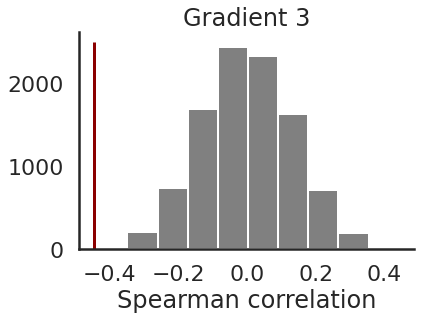

In [98]:
g=2
p=3

rs = []
surrogates = np.load(data_dir + 'results/null_models/volume/surrogates/vol{}_surrogates.npy'.format(g))
for s in range(10000):
    r_val, _ = stats.spearmanr(surrogates[s,:], pcs[:,p])
    rs.append(r_val)

r_val, _ = stats.spearmanr(gradients[:,g], pcs[:,p])
p_val = np.where(np.abs(rs)>=np.abs(r_val))[0].shape[0] / (len(rs)+1)

plt.hist(rs, color='grey', label='Surrogate maps')
plt.vlines(r_val, 0,2500, color='darkred', label='Gradient {}, Gene PC {}'.format(g+1, p+1))
plt.xlabel('Spearman correlation')
plt.title('Gradient {}'.format(g+1))
sns.despine()

In [99]:
p_val

0.0

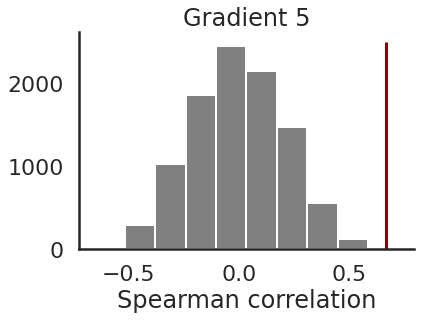

In [100]:
g=4
p=1

rs = []
surrogates = np.load(data_dir + 'results/null_models/volume/surrogates/vol{}_surrogates.npy'.format(g))
for s in range(10000):
    r_val, _ = stats.spearmanr(surrogates[s,:], pcs[:,p])
    rs.append(r_val)

r_val, _ = stats.spearmanr(gradients[:,g], pcs[:,p])
p_val = np.where(np.abs(rs)>=np.abs(r_val))[0].shape[0] / (len(rs)+1)

plt.hist(rs, color='grey', label='Surrogate maps')
plt.vlines(r_val, 0,2500, color='darkred', label='Gradient {}, Gene PC {}'.format(g+1, p+1))
plt.xlabel('Spearman correlation')
plt.title('Gradient {}'.format(g+1))
sns.despine()

In [101]:
p_val

9.999000099990002e-05